In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
url = 'https://docs.google.com/spreadsheets/d/1HcdISgCl3s4RpWkJa8m-G1JjfKzd8qf2WY2Xcw32D7U/pub?gid=1371955398&single=true&output=csv'

In [94]:
import pandas

historical_record = pandas.read_csv(url)
historical_record['Match Date'] = pandas.to_datetime(historical_record['Match Date'], infer_datetime_format=True)

In [204]:
event_dates = dict(pandas.to_datetime(
    historical_record.groupby('Event').max()['Match Date'],
    infer_datetime_format=True
))
event_dates

{'$5 Tournament': Timestamp('2015-11-01 00:00:00'),
 '19XX: Rebel 1': Timestamp('2016-10-01 00:00:00'),
 '19XX: Waifu 2': Timestamp('2017-04-29 00:00:00'),
 'Best of the Rest': Timestamp('2015-11-07 00:00:00'),
 'Bloody Sunday': Timestamp('2015-06-28 00:00:00'),
 'Brilliant Idea': Timestamp('2016-03-25 00:00:00'),
 'Choose Your Champions': Timestamp('2015-11-15 00:00:00'),
 'DRB Exhibition': Timestamp('2016-03-06 00:00:00'),
 'Double Blind': Timestamp('2015-05-09 00:00:00'),
 'Double Blind No DeGrey': Timestamp('2015-12-19 00:00:00'),
 'Double Blind Single': Timestamp('2016-10-02 00:00:00'),
 'Double Blind Sunday': Timestamp('2015-10-04 00:00:00'),
 'Double Blind Sunday 2': Timestamp('2015-10-18 00:00:00'),
 'Double Blind Sunday April 17': Timestamp('2016-04-17 00:00:00'),
 'Emperor Series I - Championship': Timestamp('2015-06-21 00:00:00'),
 'Emperor Series I - Week 1': Timestamp('2015-05-02 00:00:00'),
 'Emperor Series I - Week 2': Timestamp('2015-05-30 00:00:00'),
 'Emperor Series I

In [205]:
historical_record['Event Date'] = historical_record.apply(lambda row: event_dates[row['Event']], axis=1)

In [206]:
standard_format = historical_record[
    historical_record['Format\n(Team)']=='.'
][
    historical_record['Format\n(Restricted)']=='.'
]

/home/cpennington/.pyenv/versions/3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [207]:
win_counts = standard_format.groupby([
    'Event Date', 'Event', 'Player 1', 'Player 2'
]).sum().fillna(0)

In [212]:
from skills import Player, Team, Match, Matches
from skills.elo import EloCalculator, EloGameInfo

game_info = EloGameInfo()
calculator = EloCalculator()

ratings = {
    p: 1500
    for p in (historical_record['Player 1'].append(historical_record['Player 2'])).apply(lambda p: p.lower()).unique()
}

ratings_history = []

games = historical_record.fillna(0).groupby(['Match Date', 'Event', 'Player 1', 'Player 2']).sum().reset_index().sort_values(by=['Match Date'])

for row in games.iterrows():
    p1 = row[1]['Player 1'].lower()
    p2 = row[1]['Player 2'].lower()
    for _ in range(int(row[1]['Wins 1'])):
        match = Match([[(p1, ratings[p1])], [(p2, ratings[p2])]], [1, 2])
        new_ratings = calculator.new_ratings(match, game_info)
        ratings[p1] = new_ratings.rating_by_id(p1)
        ratings[p2] = new_ratings.rating_by_id(p2)
    for _ in range(int(row[1]['Wins 2'])):
        match = Match([[(p1, ratings[p1])], [(p2, ratings[p2])]], [2, 1])
        new_ratings = calculator.new_ratings(match, game_info)
        ratings[p1] = new_ratings.rating_by_id(p1)
        ratings[p2] = new_ratings.rating_by_id(p2)
    ratings_history.extend([
        (row[1]['Match Date'], row[1]['Event'], p1, new_ratings.rating_by_id(p1) and new_ratings.rating_by_id(p1).mean),
        (row[1]['Match Date'], row[1]['Event'], p2, new_ratings.rating_by_id(p2) and new_ratings.rating_by_id(p2).mean),
    ])
    
ratings_history = pandas.DataFrame(
    ratings_history,
    columns=['Date', 'Event', 'Player', 'Rating']
)

post_tournament_ratings = ratings_history.sort_values(by=['Date', 'Event']).groupby(['Event', 'Player']).last()
ratings_history['Event Date'] = ratings_history.reset_index().apply(lambda row: event_dates[row['Event']], axis=1).values
    

In [221]:
ratings_history.groupby('Player').mean().sort_values(by=['Rating'], ascending=False)

,Rating
Player,
deluks917,1647.715506
niijima-san,1646.212821
cpat,1639.649159
raziek,1635.015867
fivec,1629.652394
ntillerman,1618.968151
drnd,1616.286345
jengajam,1612.017653
mastrblastr,1606.954037


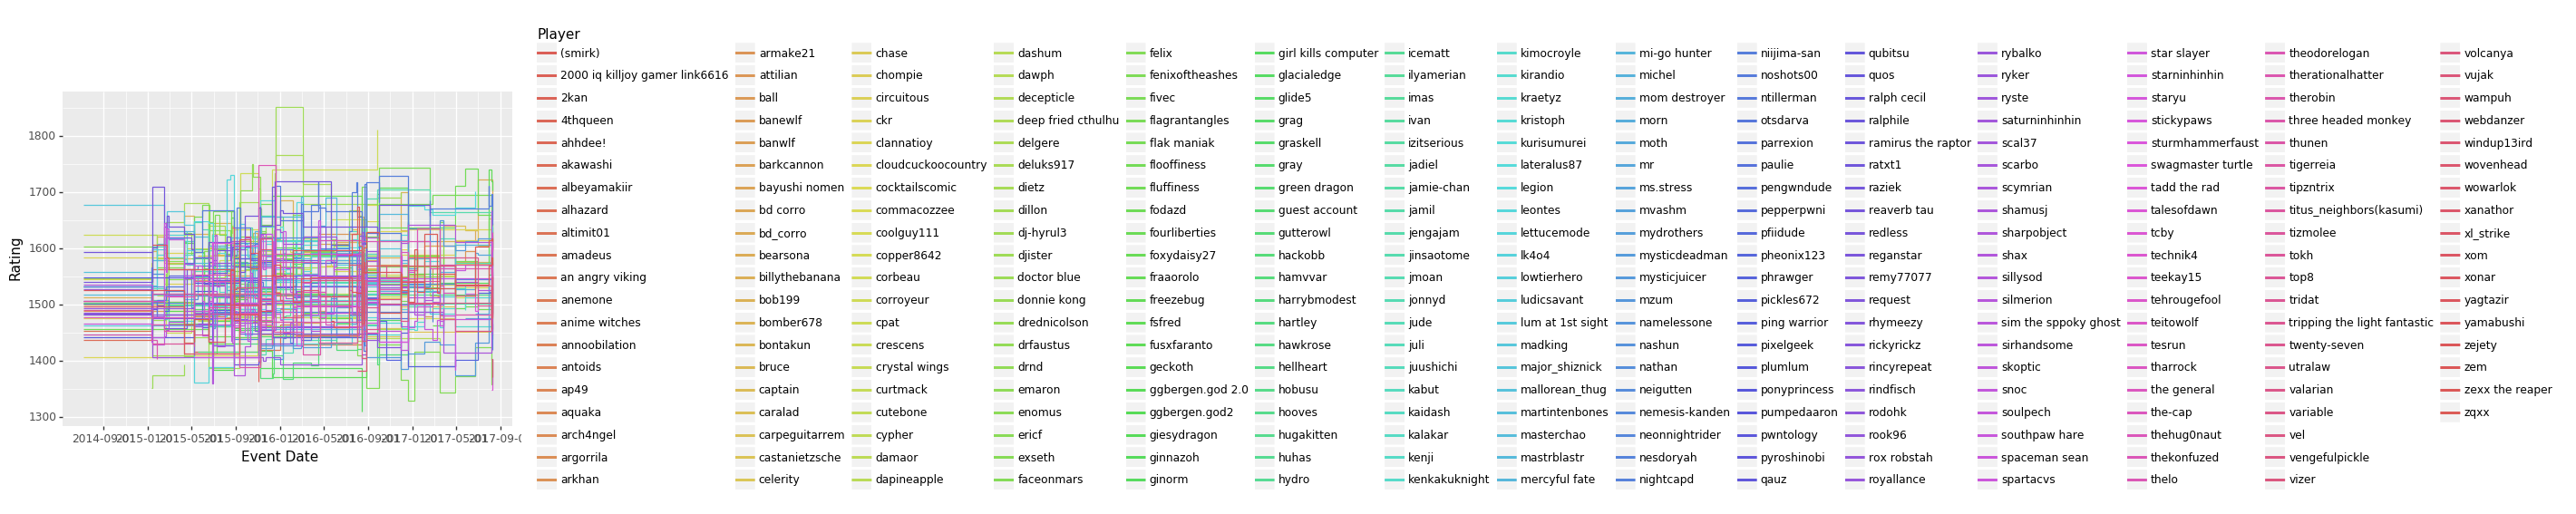

<ggplot: (8735522794041)>

In [211]:
from plotnine import *

ggplot(
    ratings_history.reset_index(),
    aes(
        x='Event Date',
        y='Rating',
        color='Player',
    )
) + geom_step()